In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


# Python 3
## Тестирование. Исключения

MIPT 2020

## Testing

Фреймворками для тестирования в питоне обычно являются `pytest` и `unittest`

In [2]:
import pytest
import ipytest
from typing import List, Any, Optional

ipytest.config(rewrite_asserts=True, magics=True)
__file__ = 'Seminar_08.ipynb'


/home/pavel/.local/lib/python3.8/site-packages/ipytest/_unittest_support.py:18: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as _pd_testing


<ConfigContext rewrite_asserts=True, magics=True, tempfile_fallback=False, clean='[Tt]est*', addopts=(), raise_on_error=False, run_in_thread=False>

In [3]:
import dataclasses

@dataclasses.dataclass
class MyList:
    data: Any
    move: Optional['MyList'] = None


In [4]:
def reverse_mylist(l: MyList) -> MyList:
    following = l.move
    while following is not None:
        new_following = following.move
        following.move = l
        l = following
        following = new_following
    return l


In [5]:
%%run_pytest[clean] -q

def test_reverse_mylist_simple():
    l = MyList(data=1)
    it = l
    for i in range(2, 5):
        it.move = MyList(data=i)
        it = it.move
    
    assert reverse_mylist(l) == it
    
    collected_data = []
    for _ in range(1, 5):
        collected_data.append(it.data)
        it = it.move
    
    assert it is None
    assert collected_data == [4, 3, 2, 1]

def test_reverse_mylist_one_item():
    l = MyList(data=1)
    
    assert reverse_mylist(l) == l
    assert l.data == 1

def test_reverse_mylist_twice():
    l = MyList(data=1)
    it = l
    for i in range(2, 100):
        it.move = MyList(data=i)
        it = it.move
    
    reversed_l = reverse_mylist(reverse_mylist(l))
    
    collected_data = []
    for _ in range(1, 100):
        collected_data.append(reversed_l.data)
        reversed_l = reversed_l.move
    
    assert reversed_l is None
    assert collected_data == list(range(1, 100))


F.
=================================== FAILURES ===================================
__________________________ test_reverse_mylist_simple __________________________

    def test_reverse_mylist_simple():
        l = MyList(data=1)
        it = l
        for i in range(2, 5):
            it.move = MyList(data=i)
            it = it.move
    
        assert reverse_mylist(l) == it
    
        collected_data = []
        for _ in range(1, 5):
            collected_data.append(it.data)
            it = it.move
    
>       assert it is None
E       assert MyList(data=2, move=MyList(data=1, move=...)) is None

<ipython-input-5-354195991196>:15: AssertionError
=========================== short test summary info ============================
FAILED Seminar_08.py::test_reverse_mylist_simple - assert MyList(data=2, move...
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! KeyboardInterrupt !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
<ipython-input-4-fe3efae09a37>:3: KeyboardInterrupt
(to show a full traceback on KeyboardInte

Ой, что-то пошло не так, надо найти баг и перезапустить тесты

In [6]:
def reverse_mylist(l: MyList) -> MyList:
    previous = None
    while l is not None:
        following = l.move
        l.move = previous
        previous = l
        l = following
    return previous


### Test-driven development

Сначала тесты, потом код. В чем плюсы и минусы?

#### pytest.parametrize

In [7]:
def shift(l: List[Any], by: int) -> None:
    l_2 = list(reversed(l))
    l_2[:by] = list(reversed(l_2[:by]))
    l_2[by:] = list(reversed(l_2[by:]))
    l[:] = l_2[:]


In [8]:
%%run_pytest[clean] -q

def test_shift_0():
    l = [0, 1, 2, 3, 4]
    l_true = l.copy()
    
    shift(l, 0)
    assert l == l_true

def test_shift_2():
    l = [0, 1, 2, 3, 4]
    l_true = [3, 4, 0, 1, 2]
    
    shift(l, 2)
    assert l == l_true

def test_shift_7():
    l = [0, 1, 2, 3, 4]
    l_true = [3, 4, 0, 1, 2]
    
    shift(l, 7)
    assert l == l_true

def test_shift_minus():
    l = [0, 1, 2, 3, 4]
    l_true = [1, 2, 3, 4, 0]
    
    shift(l, -1)
    assert l == l_true

def test_shift_empty():
    l = []
    
    shift(l, 100)
    assert not l


..F..                                                                    [100%]
=================================== FAILURES ===================================
_________________________________ test_shift_7 _________________________________

    def test_shift_7():
        l = [0, 1, 2, 3, 4]
        l_true = [3, 4, 0, 1, 2]
    
        shift(l, 7)
>       assert l == l_true
E       assert [0, 1, 2, 3, 4] == [3, 4, 0, 1, 2]
E         At index 0 diff: 0 != 3
E         Full diff:
E         - [3, 4, 0, 1, 2]
E         + [0, 1, 2, 3, 4]

<ipython-input-8-d38fb5f9b031>:20: AssertionError
=========================== short test summary info ============================
FAILED Seminar_08.py::test_shift_7 - assert [0, 1, 2, 3, 4] == [3, 4, 0, 1, 2]
1 failed, 4 passed in 0.05s


In [9]:
def shift(l: List[Any], by: int) -> None:
    if not l:
        return
    by = by % len(l)
    l_2 = list(reversed(l))
    l_2[:by] = list(reversed(l_2[:by]))
    l_2[by:] = list(reversed(l_2[by:]))
    l[:] = l_2[:]


Теперь будем чуть оптимальнее

In [10]:
%%run_pytest[clean] -q

@pytest.mark.parametrize('shift_value,l_true', [
    (0, [0, 1, 2, 3, 4]),
    (2, [3, 4, 0, 1, 2]),
    (7, [3, 4, 0, 1, 2]),
    (-1, [1, 2, 3, 4, 0]),
], ids=['zero', 'non-zero', 'out bounds', 'negative'])
def test_shift_simple(shift_value, l_true):
    l = [0, 1, 2, 3, 4]
    
    shift(l, shift_value)
    assert l == l_true

def test_shift_empty():
    l = []
    
    shift(l, 100)
    assert not l


.....                                                                    [100%]
5 passed in 0.02s


#### Monkeypatch

In [11]:
import random


def lottery(p: float, n: int) -> bool:
    lucky_number = random.randint(n)
    if lucky_number < n * p:
        return True  # congratulations, you won!
    return False  # not this time
    

Рандом в тестах - это плохо! Приводит к "флапающим тестам"

In [12]:
%%run_pytest[clean] -q

TEST_P = 0.1
TEST_N = 100

def test_lottery_win(monkeypatch):
    monkeypatch.setattr(random, 'randint', lambda x: 0)
    
    assert lottery(TEST_P, TEST_N)

def test_lottery_loss(monkeypatch):
    monkeypatch.setattr(random, 'randint', lambda x: TEST_N)
    
    assert not lottery(TEST_P, TEST_N)


..                                                                       [100%]
2 passed in 0.01s


Что это было? Откуда взялся параметр monkeypatch?

### fixtures

Приведем пример, как мокать http запросы

In [13]:
%%file get_cat.py

import aiohttp        
import aiofiles


URL = "https://cdn.pixabay.com/photo/2015/11/16/14/43/cat-1045782_960_720.jpg"


async def save_cat_image(path: str):
    async with aiohttp.ClientSession() as session:
        async with session.get(URL) as resp:
            async with aiofiles.open(path, mode='wb') as f:
                await f.write(await resp.read())


Overwriting get_cat.py


In [14]:
import aiohttp        
import aiofiles


URL = "https://cdn.pixabay.com/photo/2015/11/16/14/43/cat-1045782_960_720.jpg"


async def save_cat_image(path: str):
    async with aiohttp.ClientSession() as session:
        async with session.get(URL) as resp:
            async with aiofiles.open(path, mode='wb') as f:
                await f.write(await resp.read())

await save_cat_image('cat.jpg')

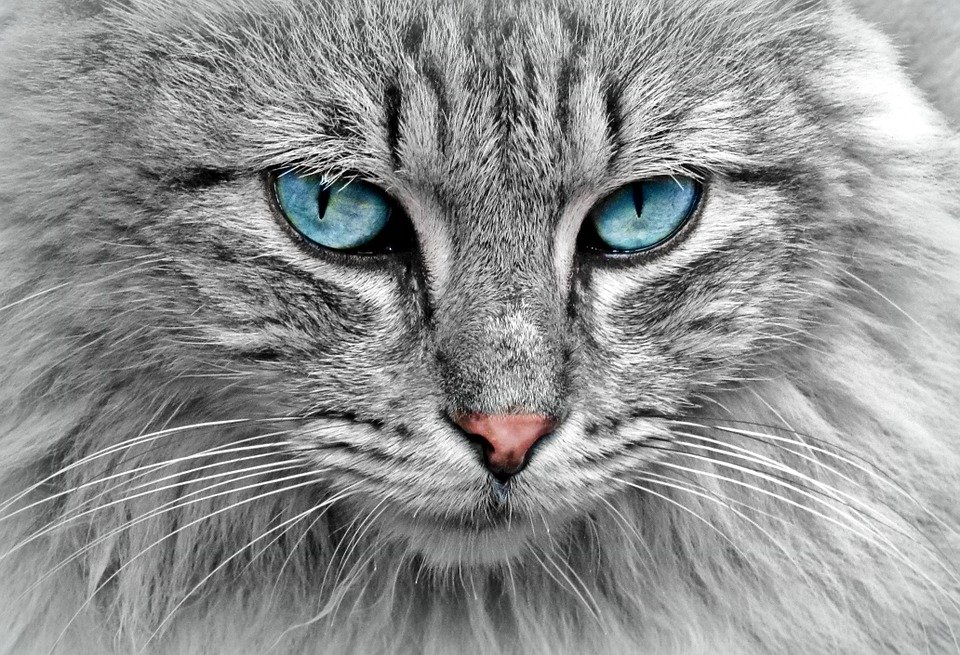

In [15]:
from IPython.display import Image
Image(filename='cat.jpg', width=500)


In [16]:
!rm cat.jpg


In [17]:
%%file test_get_cat.py
from contextlib import asynccontextmanager
import aiohttp
import aiofiles
import pytest
import io

import get_cat

TEST_BODY = "Test Message"

class Response:
    async def read(self):
        return TEST_BODY.encode()


@pytest.fixture
def mock_request(monkeypatch):
    @asynccontextmanager
    async def get_resp(*args):
        yield Response()
    
    monkeypatch.setattr(aiohttp.ClientSession, 'get', get_resp)

    
@pytest.mark.asyncio
async def test_cat_image(mock_request, tmp_path):
    path_to_save = tmp_path / 'cat.jpg'
    await get_cat.save_cat_image(path_to_save)
    
    with open(path_to_save) as cat_file:
        assert cat_file.read() == TEST_BODY


Overwriting test_get_cat.py


In [21]:
!rm get_cat.py test_get_cat.py

Оффтоп про asyncio

In [18]:
import asyncio


async def sleep_coro(num):
    await asyncio.sleep(1)
    return num

results = asyncio.gather(*[sleep_coro(num) for num in range(5)])
results.add_done_callback(lambda res: print(res.result()))
print('Haha I am faster')


Haha I am faster


## Исключения

In [19]:
def raise_func(statement: str):
    try:
        exec(statement)
    except ZeroDivisionError as e:
        print(e)
        raise
    except NameError as e:
        print(e)
        raise ValueError('I think it is ValueError') from e
    except Exception as e:
        print(e)
        raise ValueError('unknown problem occured')
    else:
        print('everything is ok')
    finally:
        print('I will be printed anyway')
    

In [20]:
try:
    raise_func('1 / 0')
except Exception as e:
    print(f'exception thrown {e}', end='\n\n')

try:
    raise_func('print(a)')
except Exception as e:
    print(f'exception thrown {e}', end='\n\n')

try:
    raise_func('def ololo')
except Exception as e:
    print(f'exception thrown {e}', end='\n\n')

try:
    raise_func('1 / 1')
except Exception as e:
    print(f'exception thrown {e}', end='\n\n')


division by zero
I will be printed anyway
exception thrown division by zero

name 'a' is not defined
I will be printed anyway
exception thrown I think it is ValueError

invalid syntax (<string>, line 1)
I will be printed anyway
exception thrown unknown problem occured

everything is ok
I will be printed anyway
